![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FDev%2Fnew&file=Geospatial+Indexing.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Dev/new/Geospatial%20Indexing.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FDev%2Fnew%2FGeospatial%2520Indexing.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Dev/new/Geospatial%20Indexing.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Dev/new/Geospatial%20Indexing.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Geospatial Indexing

https://cloud.google.com/bigquery/docs/vector-search-intro

---
## Setup

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'indexing'
SERIES = 'applied-geospatial'

In [3]:
BQ_SOURCE = 'bigquery-public-data.geo_openstreetmap.planet_features'

BQ_REGION = REGION[0:2]
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE_PREFIX = EXPERIMENT

In [4]:
import matplotlib.pyplot as plt

from google.cloud import bigquery
import bigframes.pandas as bpd

In [5]:
bq = bigquery.Client(project = PROJECT_ID)
bpd.options.bigquery.project = PROJECT_ID

In [6]:
# create/link to dataset
ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
ds.location = BQ_REGION
ds.labels = {'series': f'{SERIES}'}
ds = bq.create_dataset(dataset = ds, exists_ok = True) 

---
## Review Source

In [27]:
bq.query(query = f'''
SELECT *
FROM {BQ_SOURCE.split('.')[0]}.{BQ_SOURCE.split('.')[1]}.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS
WHERE TABLE_NAME = '{BQ_SOURCE.split('.')[2]}'
''').to_dataframe()

,table_catalog,table_schema,table_name,column_name,field_path,data_type,description,collation_name,rounding_mode
0,bigquery-public-data,geo_openstreetmap,planet_features,feature_type,feature_type,STRING,None,NULL,None
1,bigquery-public-data,geo_openstreetmap,planet_features,osm_id,osm_id,INT64,None,NULL,None
2,bigquery-public-data,geo_openstreetmap,planet_features,osm_way_id,osm_way_id,INT64,None,NULL,None
3,bigquery-public-data,geo_openstreetmap,planet_features,osm_version,osm_version,INT64,None,NULL,None
4,bigquery-public-data,geo_openstreetmap,planet_features,osm_timestamp,osm_timestamp,TIMESTAMP,None,NULL,None
5,bigquery-public-data,geo_openstreetmap,planet_features,all_tags,all_tags,"ARRAY<STRUCT<key STRING, value STRING>>",None,NULL,None
6,bigquery-public-data,geo_openstreetmap,planet_features,all_tags,all_tags.key,STRING,None,NULL,None
7,bigquery-public-data,geo_openstreetmap,planet_features,all_tags,all_tags.value,STRING,None,NULL,None
8,bigquery-public-data,geo_openstreetmap,planet_features,geometry,geometry,GEOGRAPHY,None,NULL,None


In [28]:
bq.query(query = f'SELECT * FROM `{BQ_SOURCE}` LIMIT 5').to_dataframe()

,feature_type,osm_id,osm_way_id,osm_version,osm_timestamp,all_tags,geometry
0,other_relations,8767442,<NA>,1,2018-10-02 23:36:38+00:00,[],"POLYGON((-123.2052362 39.1257422, -123.2052314..."
1,multipolygons,<NA>,710599311,1,2019-08-04 06:56:34+00:00,"[{'key': 'level', 'value': '0'}]","POLYGON((-123.2127626 39.1334776, -123.2127651..."
2,points,358763181,<NA>,1,2009-03-11 05:27:04+00:00,"[{'key': 'ele', 'value': '0'}, {'key': 'gnis:c...",POINT(-123.7272381 39.1304589)
3,points,358765882,<NA>,1,2009-03-11 05:30:36+00:00,"[{'key': 'ele', 'value': '0'}, {'key': 'gnis:c...",POINT(-123.5936233 38.7999108)
4,multipolygons,6826538,<NA>,1,2016-12-27 21:27:25+00:00,"[{'key': 'ele', 'value': '0'}, {'key': 'gnis:c...","POLYGON((-123.0778671 38.3740722, -123.0777454..."


---
## Setup For Test

### Source Table

In [49]:
query = f'''
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source` AS
    SELECT feature_type, osm_id, ST_CENTROID(geometry) as loc
    FROM `{BQ_SOURCE}`
    WHERE osm_id IS NOT NULL
'''
bq_job = bq.query(query = query)
bq_job.result()

In [50]:
(bq_job.ended - bq_job.started).total_seconds()

23.002

In [51]:
bq_job.slot_millis/1000

16978.327

### Query Table

In [39]:
query = f'''
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query` AS
    SELECT i1 * 1000 + i2 - 1000 AS id, ST_GEOGPOINT(RAND() * 360, RAND() * 180 - 90) as loc
    FROM
        UNNEST(GENERATE_ARRAY(1, 1000)) i1,
        UNNEST(GENERATE_ARRAY(1, 1000)) i2
'''
bq_job = bq.query(query = query)
bq_job.result()

In [40]:
bpd.read_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query').shape

(1000000, 2)

In [41]:
bpd.read_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query').head()

,id,loc
0,199785,POINT (-64.98862 18.17565)
1,258671,POINT (175.83260 44.64768)
2,66678,POINT (-72.16857 82.63562)
3,715496,POINT (120.96126 53.24684)
4,443791,POINT (155.22695 60.39786)


### Query Table - Partition Version
Split into 100 Partitions (max value is 4000)
- [Reference](https://cloud.google.com/bigquery/quotas#partitioned_tables)

In [7]:
query = f'''
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_queryPartitioned`
PARTITION BY RANGE_BUCKET(partID, GENERATE_ARRAY(1, 400))
AS (
    SELECT *,
        ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 400)) AS partID
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query`
)
'''
bq_job = bq.query(query = query)
bq_job.result()

In [8]:
bpd.read_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_queryPartitioned').head()

,id,loc,loc_ecef,partID
0,320867,POINT (-125.95655 8.50578),"[-0.5807132028189643, -0.8005591982501122, 0.1...",29
1,503306,POINT (77.19044 -23.15086),"[0.2038574043237758, 0.8965893563609467, -0.39...",148
2,342866,POINT (-126.94063 -50.27093),"[-0.3841258366180017, -0.5108526894106312, -0....",346
3,173289,POINT (-46.61419 57.89459),"[0.3650766449638106, -0.3862493420789399, 0.84...",352
4,494872,POINT (-158.61505 24.26105),"[-0.8489149463066968, -0.3324289482834484, 0.4...",167


---
## Geospatial Query ST_DISTANCE(): Testing

https://cloud.google.com/bigquery/docs/geospatial-intro

In [83]:
distances = [.1, 1, 10, 20, 40, 60, 80, 100, 120, 140]

In [78]:
rerun = False

if rerun:
    run_seconds = []
    slot_seconds = []
    total_neighbors = []

    for distance in distances:
        query = f'''
            SELECT id, ARRAY_AGG(osm_id ORDER BY ST_DISTANCE(q.loc, s.loc) LIMIT 10) AS neighbors
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query` q
            JOIN `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source` s
            ON ST_DWITHIN(q.loc, s.loc, 1000 * {distance})
            GROUP BY id
        '''
        bq_job = bq.query(query = query, job_config = bigquery.QueryJobConfig(use_query_cache = False))
        bq_job.result()
        run_seconds.append((bq_job.ended - bq_job.started).total_seconds())
        slot_seconds.append(bq_job.slot_millis/1000)
        temp_table = '.'.join(bq_job.destination.path.split('/')[2::2])
        temp = bpd.read_gbq(temp_table)
        temp['n_neighbors'] = temp.neighbors.str.len()
        total_neighbors.append(temp['n_neighbors'].sum())
else:
    run_seconds = [9.209, 11.92, 22.33, 39.728, 181.53, 626.919, 691.885, 2420.253, 2757.184, 5692.59]
    slot_seconds = [7862.412, 8221.25, 17288.616, 43164.958, 179803.204, 672906.964, 660971.784, 2529836.997, 2742079.948, 2714392.396]
    total_neighbors = [16971, 389401, 1691734, 2269899, 2884107, 3253185, 3546474, 3813336, 4066409, 4306270]   

In [79]:
run_seconds

[9.209,
 11.92,
 22.33,
 39.728,
 181.53,
 626.919,
 691.885,
 2420.253,
 2757.184,
 5692.59]

In [80]:
slot_seconds

[7862.412,
 8221.25,
 17288.616,
 43164.958,
 179803.204,
 672906.964,
 660971.784,
 2529836.997,
 2742079.948,
 2714392.396]

In [81]:
total_neighbors

[16971,
 389401,
 1691734,
 2269899,
 2884107,
 3253185,
 3546474,
 3813336,
 4066409,
 4306270]

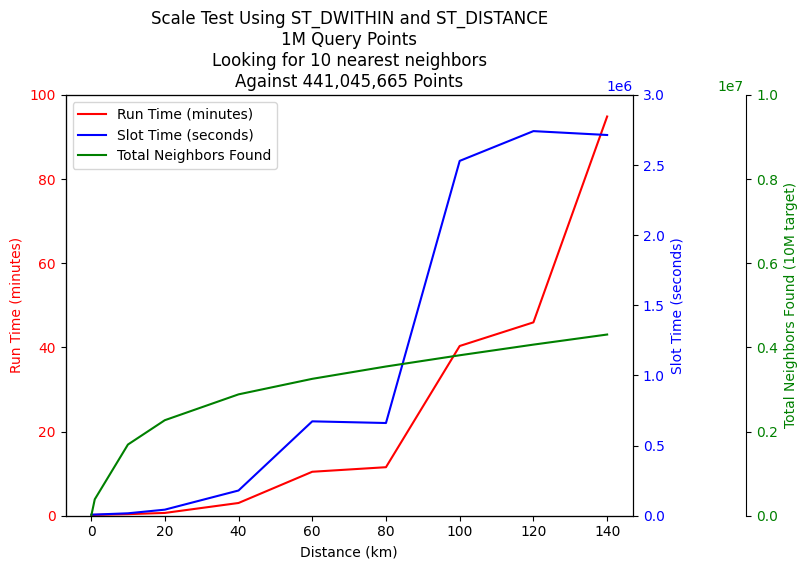

In [84]:
fig, ax1 = plt.subplots()
fig.tight_layout()
ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Run Time (minutes)', color = 'red')
ax1.tick_params(axis = 'y', labelcolor = 'red')
p1, = ax1.plot(distances, [r/60 for r in run_seconds], label = 'Run Time (minutes)', color = 'red')
ax1.set_ylim(0, 6000/60)

ax2.set_ylabel('Slot Time (seconds)', color = 'blue')
ax2.tick_params(axis = 'y', labelcolor = 'blue')
p2, = ax2.plot(distances, [s for s in slot_seconds], label = 'Slot Time (seconds)', color = 'blue')
ax2.set_ylim(0, 3000000)

ax3.set_ylabel('Total Neighbors Found (10M target)', color = 'green')
ax3.tick_params(axis = 'y', labelcolor = 'green')
p3, = ax3.plot(distances, total_neighbors, label = 'Total Neighbors Found', color = 'green')
ax3.spines.right.set_position(('axes', 1.2))
ax3.yaxis.get_offset_text().set_visible(False)
plt.text(170, 10100000, "1e7", color = 'green')
ax3.set_ylim(0, 10000000)


ax1.set_title('Scale Test Using ST_DWITHIN and ST_DISTANCE\n1M Query Points\nLooking for 10 nearest neighbors\nAgainst 441,045,665 Points')
ax1.legend(handles = [p1, p2, p3])
plt.show()

---
## Re-Projection

In the next section an alternative approach to finding neighboring points is used.  It uses indexing of arrays.  The numerical distances represented by the array need to be projected to a cartesian coordinate system.  The [Earth-fixed coordinate system (ECEF)](https://en.wikipedia.org/wiki/Earth-centered,_Earth-fixed_coordinate_system) is used here.  This is a three coordinate system representing the measurement from the center of the Earth.

In BigQuery, [working with geospatial data](https://cloud.google.com/bigquery/docs/geospatial-data) uses the geography data type which describes a point set on the Earth's surface on the [WGS84](https://earth-info.nga.mil/GandG/update/index.php?action=home#tab_wgs84-data) reference sphereoid.  The longitude can be extracted from a point with the [ST_X()](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions#st_x) function, and latitude with the [ST_Y()](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions#st_y) function.


The Math for converting WGS84 (Longitude, Latitude) to ECEF (X,Y,Z):
- $\phi$ = latitude (north/south) converted to $radians = degrees * \pi/180$
- $\lambda$ = longitude (east/west) converetd to $radians = degrees * \pi/180$
- (X, Y, Z) = ($\cos(\lambda) * \cos(\phi)$, $\sin(\lambda) * \cos(\phi)$, $\sin(\phi)$)
- Notes:
    - Coordinate system conversion: [From geodetic to ECEF](https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_geodetic_to_ECEF_coordinates)
    - Here, the points are all on the surface of the Earth approximated with: $h = 0$
    - **QUESTION** Do we need radius (major axis a = 6,378,137, minor axis b = 6,356,752.314245) to calculate $N(\phi)$ as a coefficent here? 


The math will be deployed with a [user-defined function](https://cloud.google.com/bigquery/docs/user-defined-functions) written in javascript:

```
CREATE TEMP FUNCTION ECEF(long FLOAT64, lat FLOAT64)
RETURNS ARRAY<FLOAT64>
LANGUAGE js
AS r"""
    var pi = Math.PI;
    phi = lat * (pi / 180)
    lambda = long * (pi / 180)
    x = Math.cos(lambda) * Math.cos(phi)
    y = Math.sin(lambda) * Math.cos(phi)
    z = Math.sin(phi)
    return [x, y, z]
"""
```

A prebuilt package exists that can also be used with a UDF.  Checkout [this blog](https://mentin.medium.com/st-transform-in-bigquery-project-any-coordinates-to-lng-lat-and-back-84957a39252a) convering the usage of [proj4js](https://github.com/proj4js/proj4js).


In [42]:
query = f'''
CREATE TEMP FUNCTION ECEF(long FLOAT64, lat FLOAT64)
RETURNS ARRAY<FLOAT64>
LANGUAGE js
AS r"""
    var pi = Math.PI;
    phi = lat * (pi / 180)
    lambda = long * (pi / 180)
    x = Math.cos(lambda) * Math.cos(phi)
    y = Math.sin(lambda) * Math.cos(phi)
    z = Math.sin(phi)
    return [x, y, z]
"""
;

ALTER TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source`
ADD COLUMN IF NOT EXISTS loc_ecef ARRAY<FLOAT64>;

UPDATE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source`
SET loc_ecef = ECEF(ST_X(loc), ST_Y(loc))
WHERE TRUE;

ALTER TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query`
ADD COLUMN IF NOT EXISTS loc_ecef ARRAY<FLOAT64>;

UPDATE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query`
SET loc_ecef = ECEF(ST_X(loc), ST_Y(loc))
WHERE TRUE;
'''

In [43]:
bq_job = bq.query(query = query)
bq_job.result()

In [44]:
(bq_job.ended - bq_job.started).total_seconds()

136.999

In [45]:
bq_job.slot_millis/1000

47101.064

In [46]:
bpd.read_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source').head()

,feature_type,osm_id,loc,loc_ecef
0,lines,761343319,POINT (-105.28773 27.99151),"[-0.23282206691294283, -0.8517705930310953, 0...."
1,points,5126643955,POINT (-46.63205 -23.54093),"[0.629532000783784, -0.6664576987571126, -0.39..."
2,points,2876305585,POINT (4.75358 52.63029),"[0.6048681025761045, 0.05029873122662784, 0.79..."
3,lines,618883227,POINT (33.34389 65.97625),"[0.34009861605827346, 0.22377617618280732, 0.9..."
4,points,5091929547,POINT (15.30989 68.01918),"[0.3610131303092436, 0.09882898820731839, 0.92..."


---
## BigQuery Vector Search - Indexing

Currently in preview, the project needs to be allowlisted through [this link](https://docs.google.com/forms/d/18yndSb4dTf2H0orqA9N7NAchQEDQekwWiD5jYfEkGWk/viewform?edit_requested=true).

### Delete (if exists) Vector Index On ECEF

In [17]:
query = f'''
DROP VECTOR INDEX IF EXISTS loc_ecef_1000 ON `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source`
'''
print(query)


DROP VECTOR INDEX IF EXISTS loc_ecef_1000 ON `statmike-mlops-349915.applied_geospatial.indexing_source`



In [61]:
bq_job = bq.query(query = query)
bq_job.result()

In [62]:
(bq_job.ended - bq_job.started).total_seconds()

0.343

In [63]:
bq_job.slot_millis/1000

0.0

### Create Vector Index On ECEF

In [18]:
query = f'''
CREATE OR REPLACE VECTOR INDEX loc_ecef_1000
    ON `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source`(loc_ecef)
    OPTIONS(
        INDEX_TYPE = 'IVF',
        DISTANCE_TYPE = 'EUCLIDEAN',
        IVF_OPTIONS = '{{"num_lists": 1000}}'
    );
'''
print(query)


CREATE OR REPLACE VECTOR INDEX loc_ecef_1000
    ON `statmike-mlops-349915.applied_geospatial.indexing_source`(loc_ecef)
    OPTIONS(
        INDEX_TYPE = 'IVF',
        DISTANCE_TYPE = 'EUCLIDEAN',
        IVF_OPTIONS = '{"num_lists": 1000}'
    );



In [67]:
bq_job = bq.query(query = query)
bq_job.result()

In [68]:
(bq_job.ended - bq_job.started).total_seconds()

2163.767

In [69]:
bq_job.slot_millis/1000

1835606.299

### Check Vector Index Status

In [19]:
query = f'''
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.VECTOR_INDEXES`
WHERE index_status = 'ACTIVE'
    AND table_name = '{BQ_TABLE_PREFIX}_source'
'''
print(query)


SELECT *
FROM `statmike-mlops-349915.applied_geospatial.INFORMATION_SCHEMA.VECTOR_INDEXES`
WHERE index_status = 'ACTIVE'
    AND table_name = 'indexing_source'



In [10]:
bq.query(query = query).to_dataframe()

,index_catalog,index_schema,table_name,index_name,index_status,creation_time,last_modification_time,last_refresh_time,disable_time,disable_reason,ddl,coverage_percentage,unindexed_row_count,total_logical_bytes,total_storage_bytes
0,statmike-mlops-349915,applied_geospatial,indexing_source,loc_ecef_1000,ACTIVE,2024-01-24 23:44:07.280000+00:00,2024-01-24 23:44:07.280000+00:00,2024-01-24 23:45:08.294000+00:00,NaT,None,CREATE VECTOR INDEX `loc_ecef_1000` ON `statmi...,100,0,25580680570,11046633114


### Vector Search

In [20]:
query = f'''
SELECT
    query.id AS id,
    ARRAY_AGG(base.osm_id ORDER BY distance) AS neighbors
FROM
    VECTOR_SEARCH(
        TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source`,
        'loc_ecef',
        (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query` LIMIT 5),
        top_k => 10,
        options => '{{"fraction_lists_to_search": 0.005}}'
    )
GROUP BY id
'''
print(query)
bq_job = bq.query(query = query, job_config = bigquery.QueryJobConfig(use_query_cache = False))
bq_job.result()
(bq_job.ended - bq_job.started).total_seconds()


SELECT
    query.id AS id,
    ARRAY_AGG(base.osm_id ORDER BY distance) AS neighbors
FROM
    VECTOR_SEARCH(
        TABLE `statmike-mlops-349915.applied_geospatial.indexing_source`,
        'loc_ecef',
        (SELECT * FROM `statmike-mlops-349915.applied_geospatial.indexing_query` LIMIT 5),
        top_k => 10,
        options => '{"fraction_lists_to_search": 0.005}'
    )
GROUP BY id



2.315

In [15]:
result = bq_job.to_dataframe()
result

,id,neighbors
0,2797,"[3003588, 225899427, 225898240, 225898505, 225..."
1,7080,"[269538499, 305639710, 5472236745, 2814446770,..."
2,5416,"[152813737, 233135115, 233050748, 3132996, 233..."
3,16775,"[7868368428, 7868368425, 653695289, 622938819,..."
4,6386,"[1401884037, 127360721, 1401887479, 488504568,..."


In [16]:
result['n_neighbors'] = result['neighbors'].str.len()
result

,id,neighbors,n_neighbors
0,2797,"[3003588, 225899427, 225898240, 225898505, 225...",10
1,7080,"[269538499, 305639710, 5472236745, 2814446770,...",10
2,5416,"[152813737, 233135115, 233050748, 3132996, 233...",10
3,16775,"[7868368428, 7868368425, 653695289, 622938819,...",10
4,6386,"[1401884037, 127360721, 1401887479, 488504568,...",10


---
## Vector Search: Explore

In [130]:
query = f'''
WITH
    MATCHES AS (
        SELECT query.id, base.osm_id, distance
        FROM VECTOR_SEARCH(
            TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source`, 'loc_ecef',
            (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query` LIMIT 50000), top_k => 10,
            options => '{{"fraction_lists_to_search": 0.005}}'
        )
    )
SELECT id, ARRAY_AGG(osm_id ORDER BY distance LIMIT 10) AS neighbors
FROM MATCHES
GROUP BY id
'''
bq_job = bq.query(query = query, job_config = bigquery.QueryJobConfig(use_query_cache = False))
bq_job.result()

In [131]:
(bq_job.ended - bq_job.started).total_seconds()

2807.409

In [132]:
bq_job.slot_millis/1000

203094.556

In [133]:
temp_table = '.'.join(bq_job.destination.path.split('/')[2::2])
temp = bpd.read_gbq(temp_table)
temp['n_neighbors'] = temp.neighbors.str.len()
temp['n_neighbors'].sum()

500000

**NOTES ON TESTING PHASE**

- The full 1MM query points: UNUSED with Vector indexes cannot be used in the search query
    - it showes this while running, I did not let it finish
- Limit to 5 query points: FULLY_USED
- Limit to 50 query points: FULLY_USED
- Limit to 500 query points: FULLY_USED
- Limit to 50,000 query points: FULLY_USED
    - 1/23/2024
        - timing with default = 2/1000 lists???
            - 12 min 18 sec (55775663 slot millis) job = 89ec20ce-5e64-4418-a10b-5b4b6c540a4b
        - timing with '{{"fraction_lists_to_search": 0.01}}' = 10/1000 lists:
            - 1 hr 50 min (662913362 slot millis) job = f9ffe4e6-5e9e-4aba-b6db-ff4496661d6f
    - NEW 1/24/2024
        - timing with defaults = 2/1000???
            - 8 min 56 sec (43582078 slot millis) job = 4858e1e6-83a9-4a83-ab13-d65c0fe2898e
        - timing with '{{"fraction_lists_to_search": 0.001}}' = 1/1000 lists:
            - 14 min 45 sec (28627666 slot millis) job = f97a7d78-676c-475d-82b8-11092b271811
        - timing with '{{"fraction_lists_to_search": 0.002}}' = 2/1000 lists:
            - 10 min 33 sec (58429084 slot millis) job = d6bebab1-ec42-4234-86cd-c30abe412623
        - timing with '{{"fraction_lists_to_search": 0.003}}' = 3/1000 lists:
            - 22 min 50 sec (96753804 slot millis) job = f9c66d15-de3e-4c73-9adc-42681c85a1ca
        - timing with '{{"fraction_lists_to_search": 0.005}}' = 5/1000 lists:
            - 46 min 47 sec (203094556 slot millis) job = c2ecaf48-c594-480c-a682-8ba0cd7aadf8
- Full 1MM query points with '{{"fraction_lists_to_search": 0.001}}'
    - Job failed at 6 hr 1 sec: timed out
    - job = 93e05e33-22c9-40ec-8d4b-e53868886323
    - 29534684342 slot millis
    - NEED: split into multiple jobs

---
## Vector Search: Explore With Partitioned Query Table

In [9]:
query = f'''
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_vectorResults` AS
WITH
    MATCHES AS (
        SELECT query.partID, query.id, base.osm_id, distance
        FROM VECTOR_SEARCH(
            TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source`, 'loc_ecef',
            (
                SELECT partID, id, loc_ecef
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_queryPartitioned`
                WHERE partID <= 20
                GROUP BY partID, id
            ), top_k => 10,
            options => '{{"fraction_lists_to_search": 0.001}}'
        )
    )
SELECT id, ARRAY_AGG(osm_id ORDER BY distance LIMIT 10) AS neighbors
FROM MATCHES
GROUP BY id
'''
print(query)


CREATE OR REPLACE TABLE `statmike-mlops-349915.applied_geospatial.indexing_vectorResults` AS
WITH
    MATCHES AS (
        SELECT query.partID, query.id, base.osm_id, distance
        FROM VECTOR_SEARCH(
            TABLE `statmike-mlops-349915.applied_geospatial.indexing_source`, 'loc_ecef',
            (
                SELECT partID, id, loc_ecef
                FROM `statmike-mlops-349915.applied_geospatial.indexing_queryPartitioned`
                WHERE partID <= 20
                GROUP BY partID, id
            ), top_k => 10,
            options => '{"fraction_lists_to_search": 0.001}'
        )
    )
SELECT id, ARRAY_AGG(osm_id ORDER BY distance LIMIT 10) AS neighbors
FROM MATCHES
GROUP BY id



In [ ]:
bq_job = bq.query(query = query, job_config = bigquery.QueryJobConfig(use_query_cache = False))
bq_job.result()

In [ ]:
query = f'''
DECLARE max_partition int64 DEFAULT 20; #400
DECLARE increment int64 DEFAULT 5;
DECLARE start int64 DEFAULT 2;

CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_vectorResults` AS
WITH
    MATCHES AS (
        SELECT query.partID, query.id, base.osm_id, distance
        FROM VECTOR_SEARCH(
            TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source`, 'loc_ecef',
            (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_queryPartitioned` WHERE partID = 1), top_k => 10,
            options => '{{"fraction_lists_to_search": 0.001}}'
        )
    )
SELECT id, ARRAY_AGG(osm_id ORDER BY distance LIMIT 10) AS neighbors
FROM MATCHES
GROUP BY id;

WHILE start <= max_partition DO

    INSERT INTO `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_vectorResults`
        WITH
            MATCHES AS (
                SELECT query.partID, query.id, base.osm_id, distance
                FROM VECTOR_SEARCH(
                    TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source`, 'loc_ecef',
                    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_queryPartitioned` WHERE partID BETWEEN start AND start + increment - 1), top_k => 10,
                    options => '{{"fraction_lists_to_search": 0.001}}'
                )
            )
        SELECT id, ARRAY_AGG(osm_id ORDER BY distance LIMIT 10) AS neighbors
        FROM MATCHES
        GROUP BY id;
        
    SET start = start + increment;

END WHILE;
'''
bq_job = bq.query(query = query, job_config = bigquery.QueryJobConfig(use_query_cache = False))
bq_job.result()

In [13]:
(bq_job.ended - bq_job.started).total_seconds()

1139.856

In [ ]:
bq_job.slot_millis/1000

In [15]:
temp_table = '.'.join(bq_job.destination.path.split('/')[2::2])
temp = bpd.read_gbq(temp_table)
temp['n_neighbors'] = temp.neighbors.str.len()
temp['n_neighbors'].sum()

500000

**NOTES ON TESTING PHASE**

- Limit to 50,000 query points:


---
## Vector Search: Testing

Split into concurrent queries:

In [ ]:
rerun = True

if rerun:
    run_seconds_index = []
    slot_seconds_index = []
    total_neighbors_index = []
    jobs = []
    for num_list in num_lists:
        # query table is `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query`
        # column id has values 1 to 1000000
        # one query with all 1MM rows times out so split into many queries
        # 10 inclusive ranges of id like id >=1 AND id <= 100000
        inc = 100000
        for i in range(0, 1000000, 100000):
            query = f'''
                WITH
                    MATCHES AS (
                        SELECT query.id, base.osm_id, distance
                        FROM VECTOR_SEARCH(
                            TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_source`, 'loc_ecef',
                            (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_query` WHERE id >= {i+1} AND id <= {i+100000}), top_k => 10,
                            options => '{{"fraction_lists_to_search": 0.001}}'
                        )
                    )
                SELECT id, ARRAY_AGG(osm_id ORDER BY distance LIMIT 10) AS neighbors
                FROM MATCHES
                GROUP BY id
            '''
            bq_job = bq.query(query = query, job_config = bigquery.QueryJobConfig(use_query_cache = False))
            jobs.append(bq_job)
            
        # wait on all jobs to finish:
        from time import sleep
        while not all([job.done() for job in jobs]):
            print('waiting for jobs to finish ... sleeping for 30s')
            sleep(10)
        
        max_job = 0
        total_millis = 0
        total_neighbors = 0
        for job in jobs:
            job_time = (job.ended - job.started).total_seconds()
            if job_time > max_job:
                max_job = job_time
            total_millis += job.slot_millis/1000
            temp_table = '.'.join(bq_job.destination.path.split('/')[2::2])
            temp = bpd.read_gbq(temp_table)
            temp['n_neighbors'] = temp.neighbors.str.len()
            total_neighbors += temp['n_neighbors'].sum()
        run_seconds_index.append(max_job)
        slot_seconds_index.append(total_millis)
        total_neighbors_index.append(total_neighbors)
else:
    run_seconds_index = [1705.773]
    slot_seconds_index = [480676.753]
    total_neighbors_index = [10000000]   

waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping for 10s
waiting for jobs to finish ... sleeping 

In [75]:
run_seconds_index

[1705.773]

In [76]:
slot_seconds_index

[480676.753]

In [99]:
total_neighbors_index

[10000000]

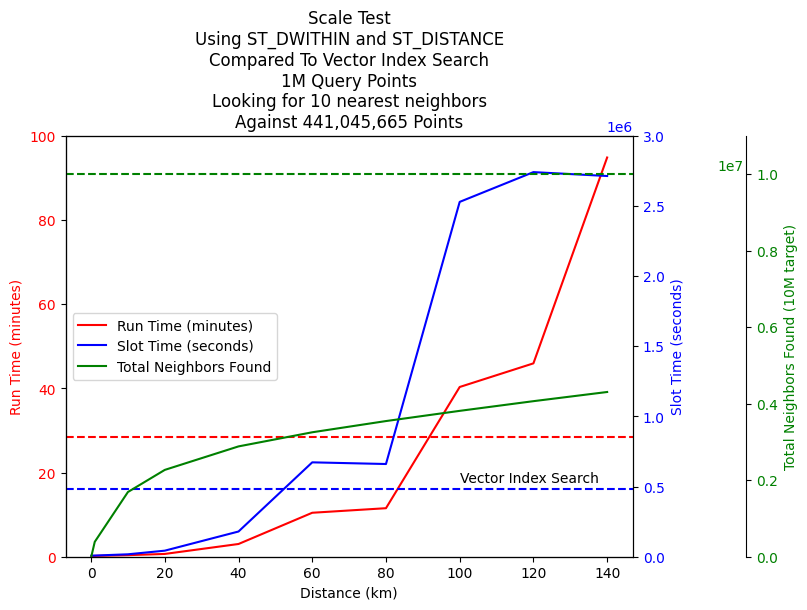

In [129]:
fig, ax1 = plt.subplots()
fig.tight_layout()
ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Run Time (minutes)', color = 'red')
ax1.tick_params(axis = 'y', labelcolor = 'red')
p1, = ax1.plot(distances, [r/60 for r in run_seconds], label = 'Run Time (minutes)', color = 'red')
ax1.set_ylim(0, 6000/60)

ax2.set_ylabel('Slot Time (seconds)', color = 'blue')
ax2.tick_params(axis = 'y', labelcolor = 'blue')
p2, = ax2.plot(distances, [s for s in slot_seconds], label = 'Slot Time (seconds)', color = 'blue')
ax2.set_ylim(0, 3000000)

ax3.set_ylabel('Total Neighbors Found (10M target)', color = 'green')
ax3.tick_params(axis = 'y', labelcolor = 'green')
p3, = ax3.plot(distances, total_neighbors, label = 'Total Neighbors Found', color = 'green')
ax3.spines.right.set_position(('axes', 1.2))
ax3.yaxis.get_offset_text().set_visible(False)
plt.text(170, 10100000, "1e7", color = 'green')
ax3.set_ylim(0, 1e7+1e6)

# add reference lines from vector index search
hl1 = ax1.axhline(y = [r/60 for r in run_seconds_index], color = 'red', linestyle = '--')
hl2 = ax2.axhline(y = slot_seconds_index, color = 'blue', linestyle = '--')
hl3 = ax3.axhline(y = total_neighbors_index, color = 'green', linestyle = '--')
ax2.text(distances[7], slot_seconds_index[0] + 50000, 'Vector Index Search')

ax1.set_title('Scale Test\nUsing ST_DWITHIN and ST_DISTANCE\nCompared To Vector Index Search\n1M Query Points\nLooking for 10 nearest neighbors\nAgainst 441,045,665 Points')
ax1.legend(handles = [p1, p2, p3], loc = 'center left')
plt.show()